In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

datadir = "/Volumes/Data/kaggle/raw"
libdir = '.'
outputdir = '.'
otherdir = '.'

train_bs_ = 16 # train_batch_size
valid_bs_ = 32 # valid_batch_size
num_workers_ = 5

In [2]:
class CFG:
    seed=42
    device='CPU'
    nprocs=1 
    num_workers=num_workers_
    train_bs=train_bs_
    valid_bs=valid_bs_
    fold_num=5 
    
    target_cols=["C1", "C2", "C3", "C4", "C5", "C6", "C7", "OT"]
    num_classes=8 
    
    accum_iter=1 
    max_grad_norm=1000 
    print_freq=100 
    normalize_mean=[0.4824, 0.4824, 0.4824] 
    normalize_std=[0.22, 0.22, 0.22] 
    
    suffix="109" 
    fold_list=[0] 
    epochs=15
    model_arch="efficientnet-b0"
    img_size=320 
    optimizer="AdamW" 
    scheduler="CosineAnnealingLR"
    loss_fn="BCEWithLogitsLoss"
    scheduler_warmup= "GradualWarmupSchedulerV3"

    warmup_epo=1
    warmup_factor = 10
    T_max= epochs-warmup_epo-2 if scheduler_warmup=="GradualWarmupSchedulerV2" else \
           epochs-warmup_epo-1 if scheduler_warmup=="GradualWarmupSchedulerV3" else epochs-1
   
    lr=5e-3 
    min_lr=1e-6 #
    weight_decay=0 
    
    n_early_stopping=5

In [3]:
import sys; 

package_paths = [f'{libdir}pytorch-image-models-master']
for pth in package_paths:
    sys.path.append(pth)
    
import ast
from glob import glob
import cv2
from skimage import io
import os
from datetime import datetime
import time
import random
from tqdm import tqdm
from contextlib import contextmanager
import math

import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
from sklearn.model_selection import GroupKFold, StratifiedKFold, KFold
import torch
import torchvision
from torchvision import transforms
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.optim import Adam, SGD, AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler
import timm
import warnings
import joblib
from scipy.ndimage.interpolation import zoom
import nibabel as nib
import pydicom as dicom
import gc 


if CFG.device == 'TPU':
    !pip install -q pytorch-ignite
    import ignite.distributed as idist
elif CFG.device == 'CPU':
    from torch.cuda.amp import autocast, GradScaler

/Users/inventrohyder/Downloads/rsna-cervical-spine/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/v4/6lzcc_4j4qn2hj39qtyjtc_80000gn/T/ipykernel_15439/2313945325.py:41: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import zoom


In [4]:
train_df = pd.read_csv(f'{datadir}/seg_25d.csv')
print('train_df shape:', train_df.shape)
train_df.head(3)

train_df shape: (29658, 6)


,id,StudyInstanceUID,slice_num,image_path,mask_path,fold
0,1.2.826.0.1.3680043.2243_1,1.2.826.0.1.3680043.2243,1,/Volumes/Data/kaggle/raw/seg_25d_image/1.2.826...,/Volumes/Data/kaggle/raw/seg_25d_mask/1.2.826....,1
1,1.2.826.0.1.3680043.2243_2,1.2.826.0.1.3680043.2243,2,/Volumes/Data/kaggle/raw/seg_25d_image/1.2.826...,/Volumes/Data/kaggle/raw/seg_25d_mask/1.2.826....,1
2,1.2.826.0.1.3680043.2243_3,1.2.826.0.1.3680043.2243,3,/Volumes/Data/kaggle/raw/seg_25d_image/1.2.826...,/Volumes/Data/kaggle/raw/seg_25d_mask/1.2.826....,1


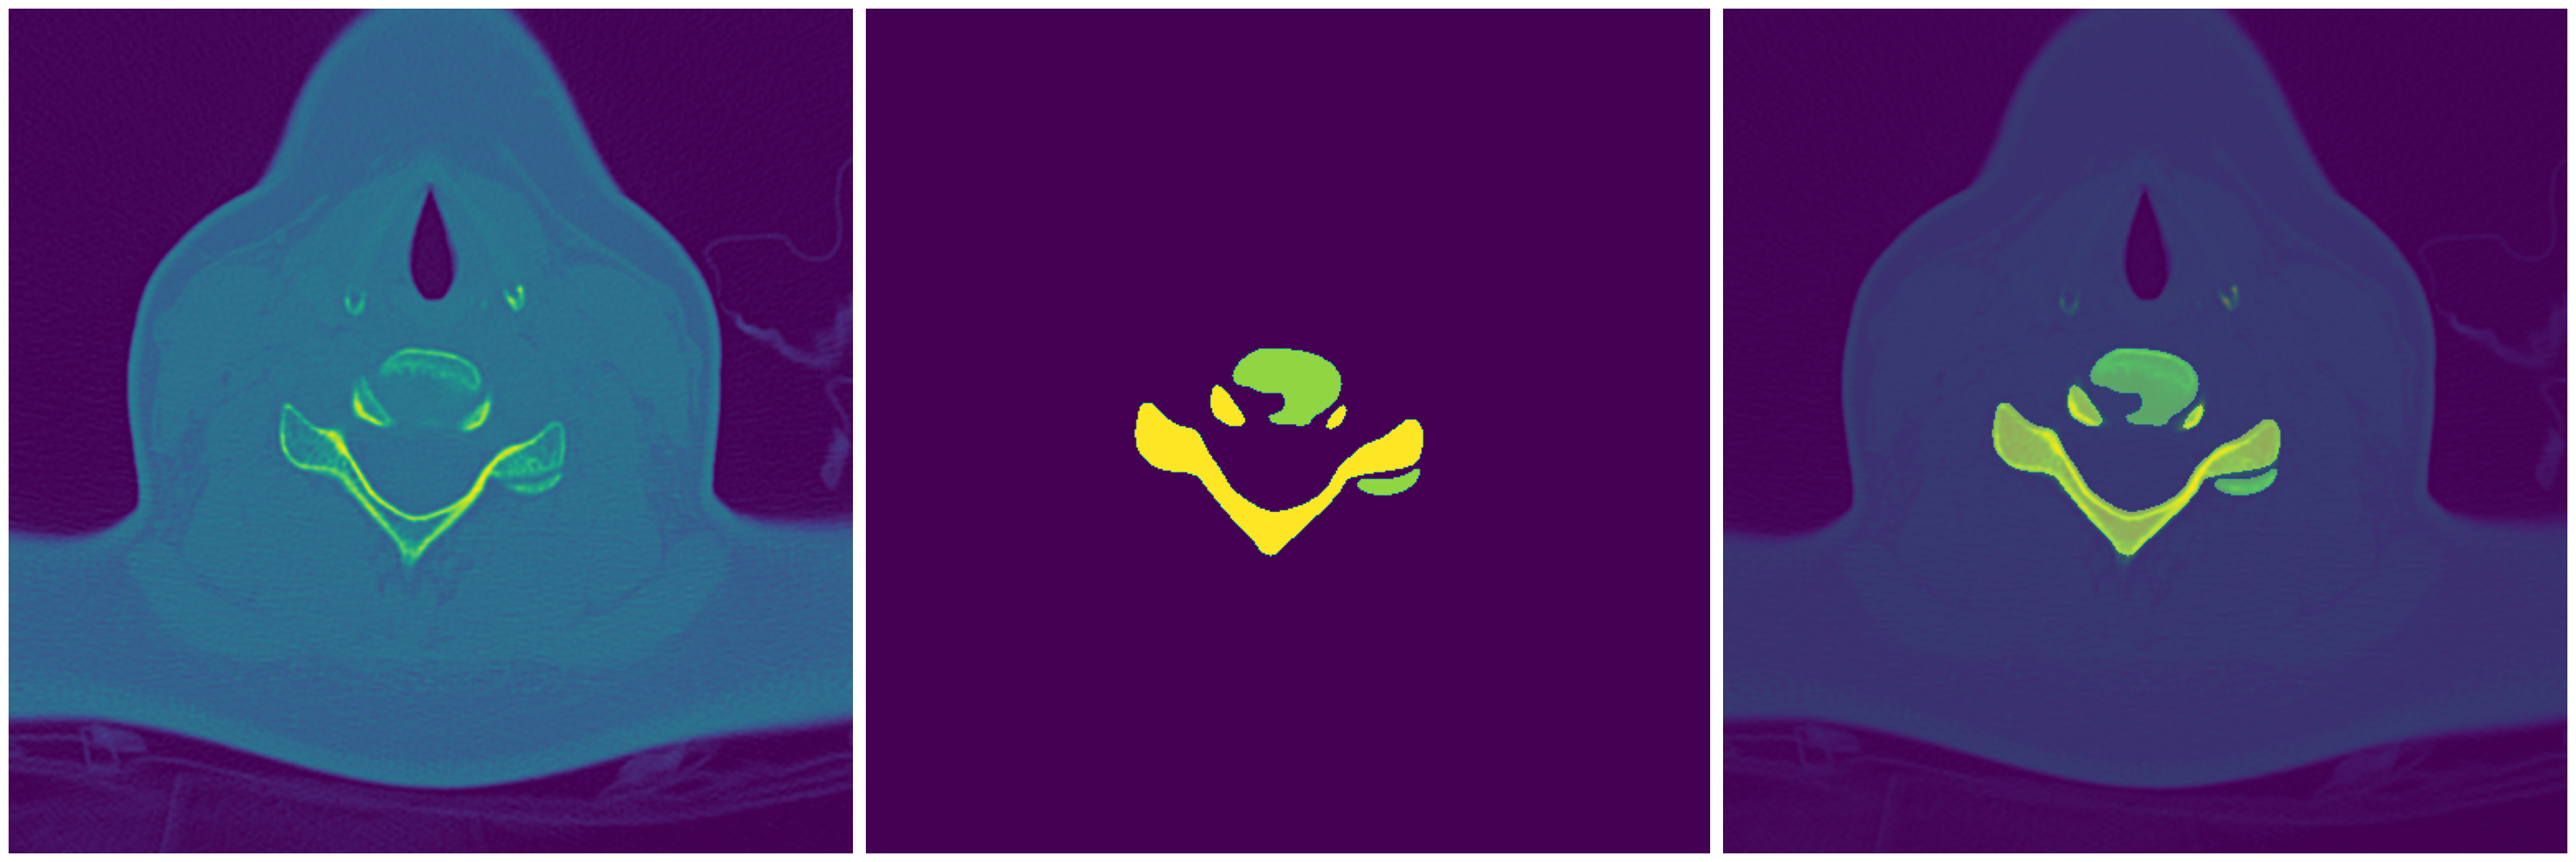

In [5]:
example_name = "1.2.826.0.1.3680043.780_147"
image_example = np.load(f"{datadir}/seg_25d_image/{example_name}.npy").transpose(2,0,1)
mask_example = np.load(f"{datadir}/seg_25d_mask/{example_name}.npy").transpose(2,0,1)
plt.figure(figsize=(30, 20))
plt.subplot(1, 3, 1); plt.imshow(image_example[1]); plt.axis('OFF');
plt.subplot(1, 3, 2); plt.imshow(mask_example[1]); plt.axis('OFF');
plt.subplot(1, 3, 3); plt.imshow(image_example[1]); plt.imshow(mask_example[1],alpha=0.5); plt.axis('OFF');
# plt.colorbar()
plt.tight_layout()
plt.show()

In [6]:
if CFG.device == 'TPU':
    import os
    VERSION = "1.7"
    CP_V = "36" if ENV == "colab" else "37"
    wheel = f"torch_xla-{VERSION}-cp{CP_V}-cp{CP_V}m-linux_x86_64.whl"
    url = f"https://storage.googleapis.com/tpu-pytorch/wheels/{wheel}"
    !pip3 -q install cloud-tpu-client==0.10 $url
    os.system('export XLA_USE_BF16=1')
    import torch_xla.core.xla_model as xm
    import torch_xla.distributed.parallel_loader as pl
    import torch_xla.distributed.xla_multiprocessing as xmp
    CFG.lr = CFG.lr * CFG.nprocs
    CFG.train_bs = CFG.train_bs // CFG.nprocs
    device = xm.xla_device()
elif CFG.device == "CPU":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True 

seed_everything(CFG.seed)


def get_score(y_true, y_pred):
    scores = []
    for i in range(y_true.shape[1]):
        score = roc_auc_score(y_true[:,i], y_pred[:,i])
        scores.append(score)
    avg_score = np.mean(scores)
    return avg_score, scores


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')

def init_logger(log_file=outputdir+'/train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger(outputdir+f'/train{CFG.suffix}.log')

if CFG.device=='TPU' and CFG.nprocs==8:
    loginfo = xm.master_print
    cusprint = xm.master_print
else:
    loginfo = LOGGER.info
    cusprint = print

def get_result(result_df):
    preds = result_df[[f'pred_{c}' for c in CFG.target_cols]].values
    labels = result_df[CFG.target_cols].values
    score, scores = get_score(labels, preds)
    LOGGER.info(f'Score: {score:<.4f}  Scores: {np.round(scores, decimals=4)}')


def get_timediff(time1,time2):
    minute_,second_ = divmod(time2-time1,60)
    return f"{int(minute_):02d}:{int(second_):02d}"  


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    return im_rgb


def load_dicom(path):
    """
    This supports loading both regular and compressed JPEG images. 
    See the first sell with `pip install` commands for the necessary dependencies
    """
    img = dicom.dcmread(path)
    img.PhotometricInterpretation = 'YBR_FULL'
    data = img.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return cv2.cvtColor(data, cv2.COLOR_GRAY2RGB), img

In [8]:
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['id'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        image = np.load(f"{datadir}/seg_25d_image/{file_name}.npy") # 512 * 512 * 3
        mask = np.load(f"{datadir}/seg_25d_mask/{file_name}.npy") # 512 * 512 * 3

        # transform
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        image = image/255.0


        real_mask = np.zeros([CFG.num_classes, CFG.img_size, CFG.img_size])  # 8 * img_size * img_size
        for idx in range(CFG.num_classes):
            mask_bool = (mask[:,:,1] == (idx+1))
            real_mask[idx] = mask_bool 
        
        image = np.transpose(image, (2, 0, 1)) # 3 * img_size * img_size
        mask = np.transpose(mask, (2, 0, 1)) # 3 * img_size * img_size

        return torch.from_numpy(image), torch.from_numpy(real_mask), torch.from_numpy(mask)

In [9]:
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, 
    CenterCrop, Resize, RandomCrop, GaussianBlur, JpegCompression, Downscale, ElasticTransform
)
import albumentations

from albumentations.pytorch import ToTensorV2

def get_transforms(data):
    if data == 'train':
        return Compose([
            Resize(CFG.img_size, CFG.img_size, interpolation=cv2.INTER_NEAREST),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
            OneOf([
                GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
                OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
                ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
            ], p=0.25),
            CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//20, max_width=CFG.img_size[1]//20,
                            min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
            ], p=1.0)

    elif data == 'light_train':
        return Compose([
            Resize(CFG.img_size, CFG.img_size, interpolation=cv2.INTER_NEAREST),
            HorizontalFlip(p=0.5),
            # VerticalFlip(p=0.5),
            ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
            OneOf([
                GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
                # OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
                ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
            ], p=0.25),
            # CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//20, max_width=CFG.img_size[1]//20,
            #              min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
            ], p=1.0)

    elif data == 'valid':
        return Compose([
            Resize(CFG.img_size, CFG.img_size, interpolation=cv2.INTER_NEAREST),
        ])

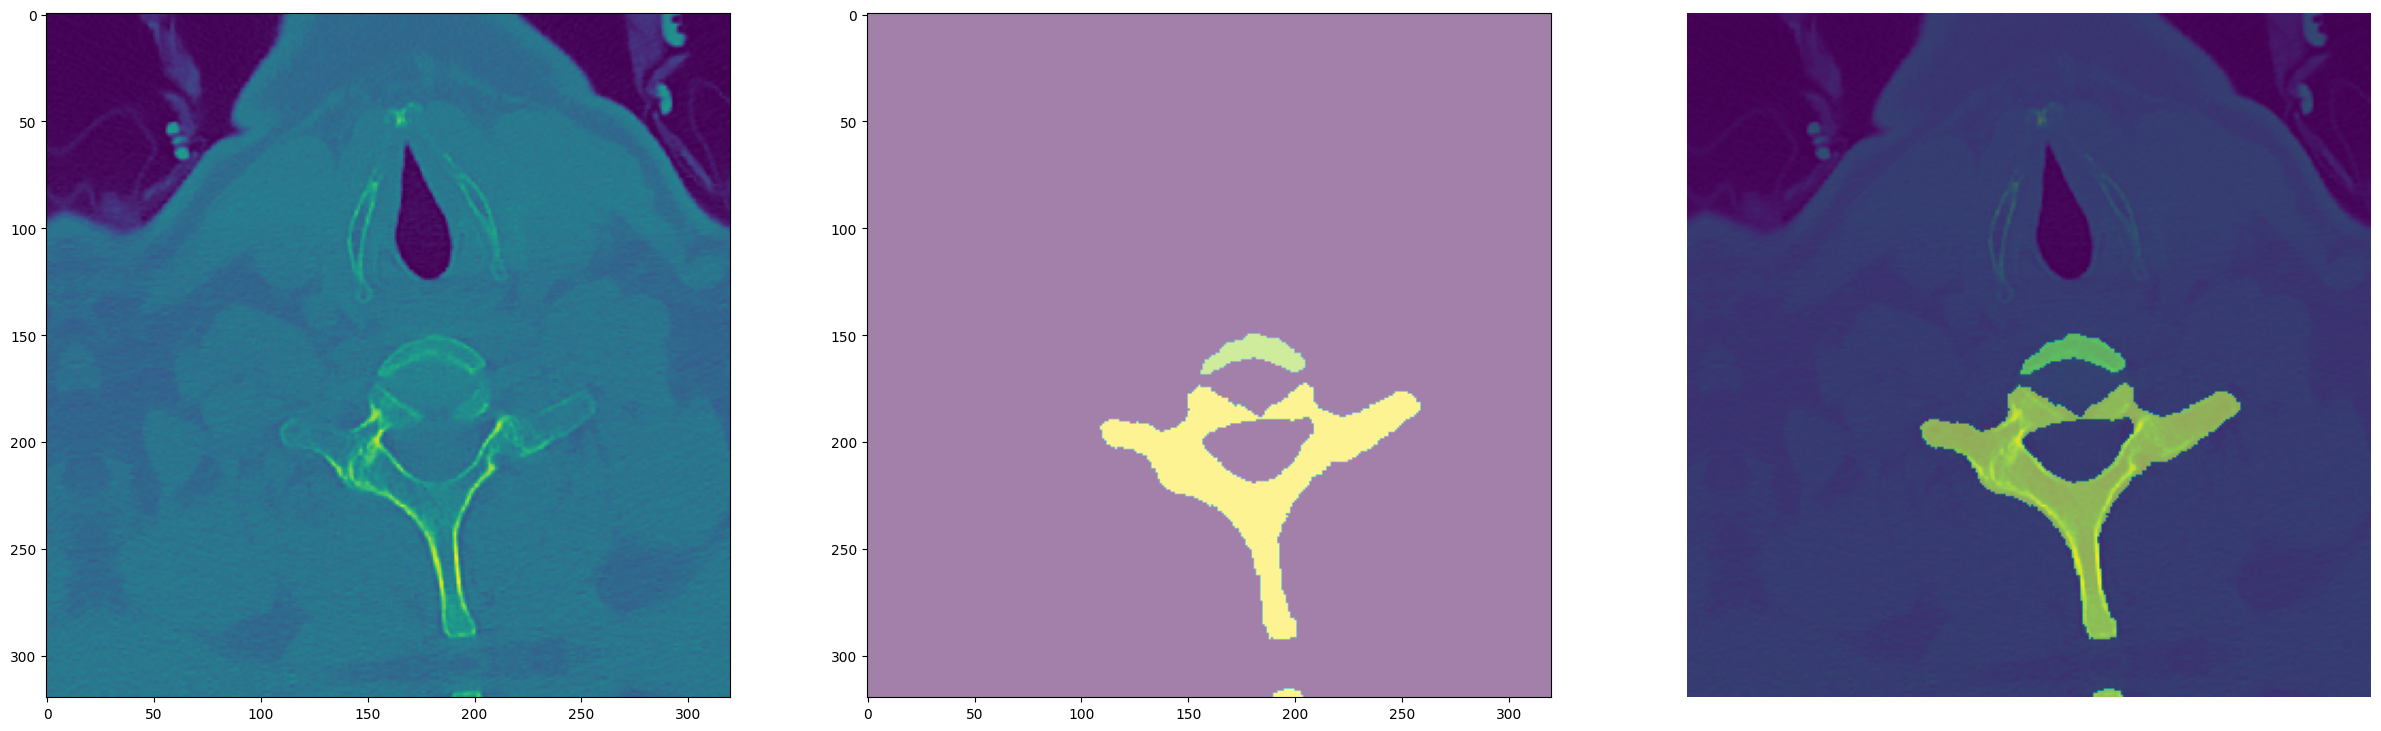

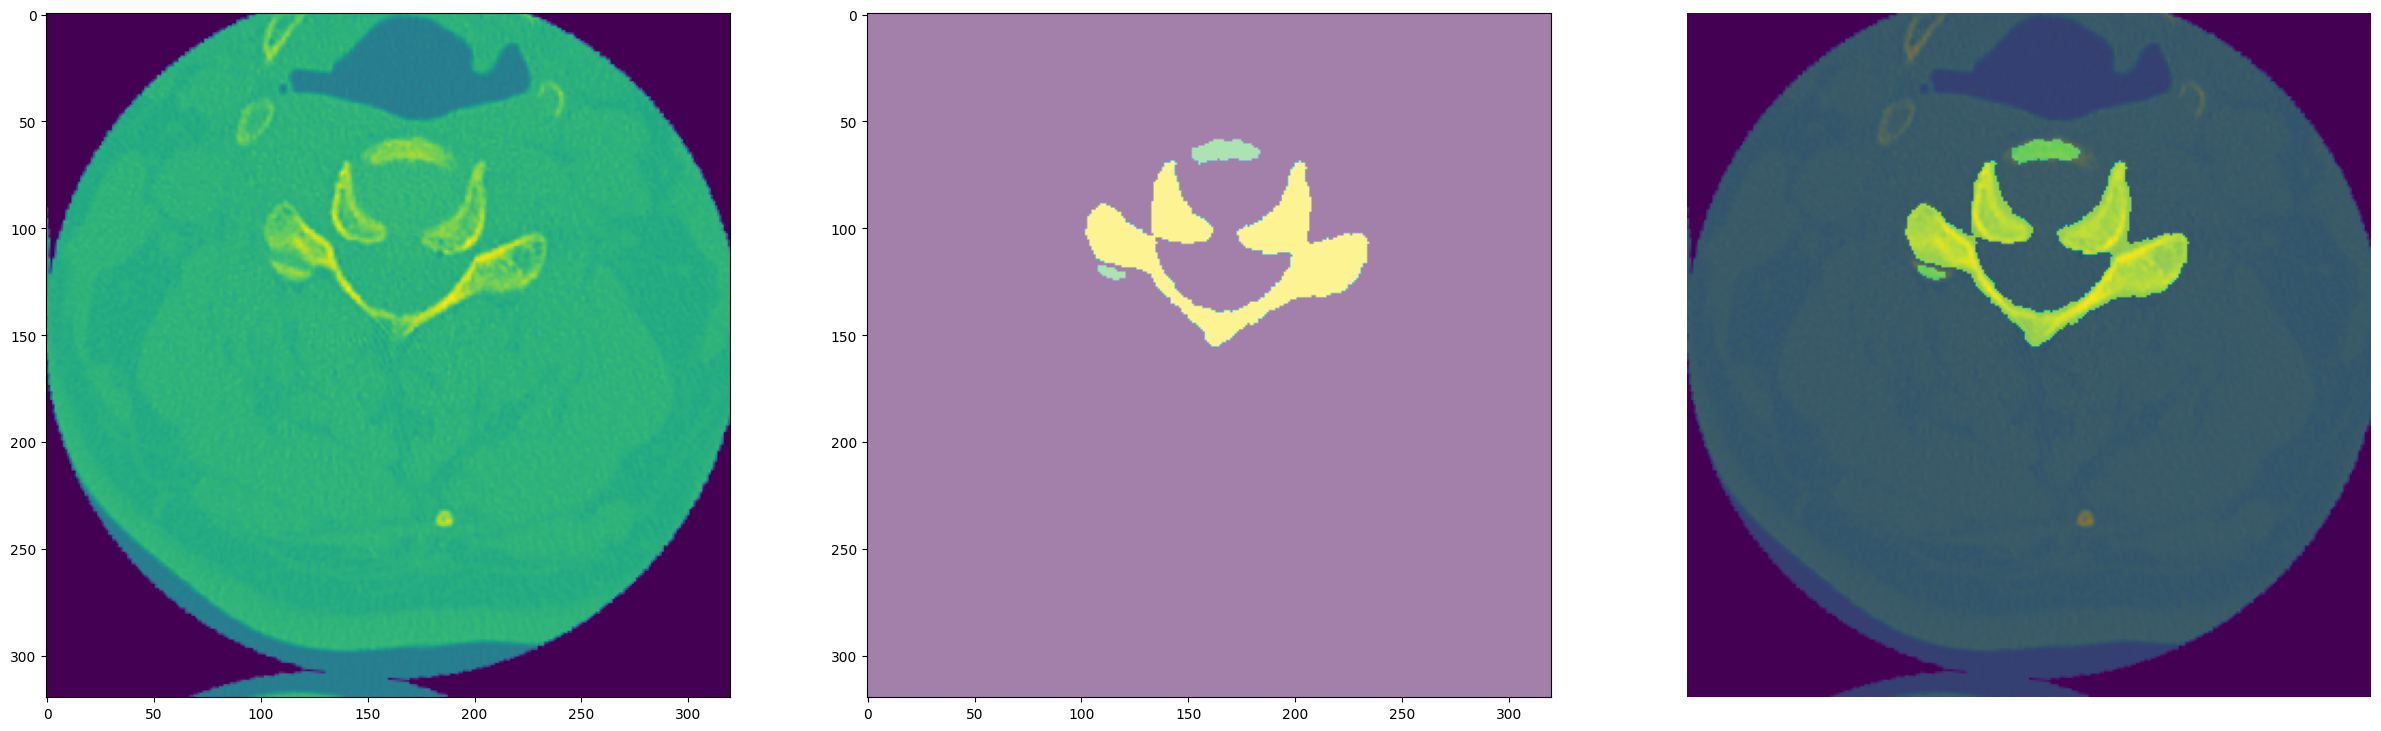

In [10]:
from pylab import rcParams
dataset_show = TrainDataset(
    train_df, 
    get_transforms("light_train") # None, get_transforms("train")
    )
rcParams['figure.figsize'] = 30,20
for i in range(2):
    f, axarr = plt.subplots(1,3)
    idx = np.random.randint(0, len(dataset_show))
    img, mask, raw_mask = dataset_show[idx]
    # axarr[p].imshow(img) # transform=None
    axarr[0].imshow(img[1]); plt.axis('OFF');
    axarr[1].imshow(raw_mask[1]/255, alpha=0.5); plt.axis('OFF');
    axarr[2].imshow(img[1]); axarr[2].imshow(raw_mask[1]/255,alpha=0.5); plt.axis('OFF');

In [11]:
import segmentation_models_pytorch as smp

def build_model():
    model = smp.Unet(
        encoder_name=CFG.model_arch,    # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=CFG.num_classes,        # model output channels (number of classes in your dataset)
        activation=None,
    )
    model.to(device)
    return model

def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

In [12]:
JaccardLoss = smp.losses.JaccardLoss(mode='multilabel')
DiceLoss    = smp.losses.DiceLoss(mode='multilabel')
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
LovaszLoss  = smp.losses.LovaszLoss(mode='multilabel', per_image=False)
TverskyLoss = smp.losses.TverskyLoss(mode='multilabel', log_loss=False)

def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

In [13]:
def train_one_epoch(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    if CFG.device == 'CPU':
        scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    model.train()
    start = end = time.time()
    for step, (images, masks, raw_mask) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device, dtype=torch.float)
        masks = masks.to(device, dtype=torch.float)
        batch_size = images.size(0)

        if CFG.device == 'CPU':
            with autocast(enabled=True):
                y_preds = model(images)
                loss = criterion(y_preds, masks)
            # record loss
            losses.update(loss.item(), batch_size)
            if CFG.accum_iter > 1:
                loss = loss / CFG.accum_iter
            scaler.scale(loss).backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
            if (step + 1) % CFG.accum_iter == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
        elif CFG.device == 'TPU':
            y_preds = model(images)
            loss = criterion(y_preds, masks)
            # record loss
            losses.update(loss.item(), batch_size)
            if CFG.accum_iter > 1:
                loss = loss / CFG.accum_iter
            loss.backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
            if (step + 1) % CFG.accum_iter == 0:
                xm.optimizer_step(optimizer, barrier=True)
                optimizer.zero_grad()
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            cusprint('Epoch: [{0}][{1}/{2}] '
                'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                'Elapsed {remain:s} '
                'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                'Grad: {grad_norm:.4f}  '
                'LR: {lr:.7f}  '
                .format(
                epoch, step, len(train_loader), batch_time=batch_time,
                data_time=data_time, loss=losses,
                remain=timeSince(start, float(step+1)/len(train_loader)),
                grad_norm=grad_norm,
                lr=optimizer.param_groups[0]["lr"],
                ))

    return losses.avg, optimizer.param_groups[0]["lr"]

In [14]:
def valid_one_epoch(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    start = end = time.time()
    val_scores = []
    for step, (images, masks, raw_mask) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device, dtype=torch.float)
        masks = masks.to(device, dtype=torch.float)
        batch_size = images.size(0)
        # compute loss
        with torch.no_grad():
            y_pred = model(images)
        loss = criterion(y_pred, masks)
        losses.update(loss.item(), batch_size)

        # record accuracy
        y_pred = y_pred.sigmoid() ####
        # y_pred = y_pred.sigmoid().to('cpu').numpy()
        val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
        val_scores.append([val_dice])

        if CFG.accum_iter > 1:
            loss = loss / CFG.accum_iter
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            cusprint('EVAL: [{0}/{1}] '
                'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                'Elapsed {remain:s} '
                'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                .format(
                step, len(valid_loader), batch_time=batch_time,
                data_time=data_time, loss=losses,
                remain=timeSince(start, float(step+1)/len(valid_loader)),
                ))

    val_scores = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()
    return losses.avg, val_scores

In [15]:
class GradualWarmupSchedulerV3(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV3, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch >= self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

In [16]:
def train_loop(df, fold):
    loginfo(f"========== fold: {fold} training ==========")
    # ====================================================
    # loader 
    # ====================================================
    train_folds = train_df[train_df["fold"] != fold].reset_index(drop=True)
    valid_folds = train_df[train_df["fold"] == fold].reset_index(drop=True)

    train_dataset = TrainDataset(train_folds, transform=get_transforms(data='light_train'))
    valid_dataset = TrainDataset(valid_folds, transform=get_transforms(data='valid'))
    if CFG.device == 'CPU':
        train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs, shuffle=True, num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
        valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs, shuffle=False, num_workers=0, pin_memory=True, drop_last=False)
    elif CFG.device == 'TPU':
        train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset, num_replicas=xm.xrt_world_size(), rank=xm.get_ordinal(), shuffle=True)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=CFG.train_bs, sampler=train_sampler, drop_last=True, num_workers=CFG.num_workers)
        valid_sampler = torch.utils.data.distributed.DistributedSampler(valid_dataset, num_replicas=xm.xrt_world_size(), rank=xm.get_ordinal(), shuffle=False)
        valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=CFG.valid_bs, sampler=valid_sampler, drop_last=False, num_workers=CFG.num_workers)

    # ====================================================
    # model & optimizer & scheduler & loss 
    # ====================================================
    model = build_model()

    # optimizer
    if CFG.optimizer == "AdamW":
        if CFG.scheduler_warmup in ["GradualWarmupSchedulerV2","GradualWarmupSchedulerV3"]:
            optimizer = AdamW(model.parameters(), lr=CFG.lr/CFG.warmup_factor, weight_decay=CFG.weight_decay) 
        else:
            optimizer = AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)  
    # scheduler
    if CFG.scheduler=='ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
    elif CFG.scheduler=='CosineAnnealingLR':
        scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
    elif CFG.scheduler=='CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)

    if CFG.scheduler_warmup=="GradualWarmupSchedulerV3":
        scheduler_warmup = GradualWarmupSchedulerV3(optimizer, multiplier=10, total_epoch=CFG.warmup_epo, after_scheduler=scheduler)

    # loss
    def criterion(y_pred, y_true):
        return 0.5*BCELoss(y_pred, y_true) + 0.5*DiceLoss(y_pred, y_true)

    # ====================================================
    # loop 
    # ====================================================

    valid_acc_max=0
    valid_acc_max_cnt=0
    for epoch in range(CFG.epochs):
        loginfo(f"***** Epoch {epoch} *****")
        if CFG.scheduler_warmup in ["GradualWarmupSchedulerV2","GradualWarmupSchedulerV3"]:
            pass
            # loginfo(f"schwarmup_last_epoch:{scheduler_warmup.last_epoch}, schwarmup_lr:{scheduler_warmup.get_last_lr()[0]}")
        if CFG.scheduler=='CosineAnnealingLR':
            loginfo(f"scheduler_last_epoch:{scheduler.last_epoch}, scheduler_lr:{scheduler.get_last_lr()[0]}")
        loginfo(f"optimizer_lr:{optimizer.param_groups[0]['lr']}")
                
        start_time = time.time() # 记录当前时间

        # train
        if CFG.device == 'TPU' and CFG.nprocs == 8:
            para_train_loader = pl.ParallelLoader(train_loader, [device])
            avg_loss, cur_lr = train_one_epoch(para_train_loader.per_device_loader(device), model, criterion, optimizer, epoch, scheduler, device)
        else:
            avg_loss, cur_lr = train_one_epoch(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # valid
        if CFG.device == 'TPU' and CFG.nprocs == 8:
            para_valid_loader = pl.ParallelLoader(valid_loader, [device])
            avg_val_loss, valid_scores = valid_one_epoch(para_valid_loader.per_device_loader(device), model, criterion, device)
            preds = idist.all_gather(torch.tensor(preds)).to('cpu').numpy()
            valid_labels = idist.all_gather(torch.tensor(valid_labels)).to('cpu').numpy()
        else:
            avg_val_loss, valid_scores = valid_one_epoch(valid_loader, model, criterion, device)

        # scoring
        elapsed = time.time() - start_time
        
        # print("valid_scores:", valid_scores, type(valid_scores))
        valid_scores = valid_scores[0]
        loginfo(f'Epoch {epoch} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        loginfo(f'Epoch {epoch} - Score: {valid_scores:.4f}')
        
        if CFG.scheduler_warmup in ["GradualWarmupSchedulerV2","GradualWarmupSchedulerV3"]:
            scheduler_warmup.step()
        elif CFG.scheduler == "ReduceLROnPlateau":
            scheduler.step(avg_val_loss)
        elif CFG.scheduler in ["CosineAnnealingLR", "CosineAnnealingWarmRestarts"]:
            scheduler.step()

        if CFG.device == 'CPU':
            torch.save({'model': model.state_dict()}, outputdir+f'/{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{epoch}.pth')
        elif CFG.device == 'TPU':
            xm.save({'model': model.state_dict()}, outputdir+f'/{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{epoch}.pth')

        # early stopping 
        if valid_scores > valid_acc_max:
            valid_acc_max = valid_scores
            valid_acc_max_cnt=0
            best_acc_epoch = epoch
        else:
            valid_acc_max_cnt+=1


        if valid_acc_max_cnt >= CFG.n_early_stopping:
            if CFG.device == 'CPU':
                torch.save({'model': model.state_dict()}, outputdir+f'/{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{epoch}.pth')
            elif CFG.device == 'TPU':
                xm.save({'model': model.state_dict()}, outputdir+f'/{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{epoch}.pth')
            print("early_stopping")
            break
        
        if CFG.device == 'CPU':
            torch.save({'model': model.state_dict()}, outputdir+f'/{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{epoch}.pth')
        elif CFG.device == 'TPU':
            xm.save({'model': model.state_dict()}, outputdir+f'/{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{epoch}.pth')

In [17]:
def main():
    for fold in range(CFG.fold_num):
        if fold in CFG.fold_list:
            train_loop(train_df, fold)

In [18]:
if __name__ == '__main__':
    print(CFG.suffix)
    if CFG.device == 'TPU':
        def _mp_fn(rank, flags):
            torch.set_default_tensor_type('torch.FloatTensor')
            a = main()
        FLAGS = {}
        xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=CFG.nprocs, start_method='fork')
    elif CFG.device == 'CPU':
        main()

========== fold: 0 training ==========


109


***** Epoch 0 *****
scheduler_last_epoch:0, scheduler_lr:0.0005
optimizer_lr:0.0005
/Users/inventrohyder/Downloads/rsna-cervical-spine/.venv/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/inventrohyder/anaconda3/envs/dstut/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/inventrohyder/anaconda3/envs/dstut/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'TrainDataset' on <module '__main__' (built-in)>


KeyboardInterrupt: 

In [ ]:
# save as cpu
if CFG.device == 'TPU':
    for fold in range(CFG.fold_num):
        if fold in CFG.fold_list:
            # best score
            state = torch.load(outputdir+f'{CFG.model_arch}_{CFG.suffix}_fold{fold}.pth')
            torch.save({'model': state['model'].to('cpu').state_dict(), 'preds': state['preds'], 'cur_best_list': state['cur_best_list']}, 
                    outputdir+f'{CFG.model_arch}_{CFG.suffix}_fold{fold}.pth')